In [2]:
# !pip install lifetimes

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime as dt
import seaborn as sns
from operator import attrgetter
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

#Import specific libraries for RFM analysis
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [4]:
data_ = pd.read_csv("online_retail_II.csv")
#This makes sure python knows that it's a brand new df, not a reference to an old one. 
data = data_.copy()

# Explore

In [5]:
data.shape

(1067371, 8)

In [6]:
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [7]:
data.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [8]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
def df_info(df):
    print("########### Shape ###########")
    print(df.shape)
    print("########### Data Types ###########")
    print(df.dtypes)    
    print("########### Head ###########")
    print(df.head())
    print("########### Tail ###########")
    print(df.tail())
    print("########### Info ###########")
    print(df.info())
    print("########### Columns ###########")
    print(df.columns)
    print("########### Quantiles ###########")
    print(df.describe().T)
    print("########### NA ###########")
    print(df.isnull().sum())
    print("########### Duplicates ###########")
    print(df.duplicated().sum())

In [10]:
df_info(data)

########### Shape ###########
(1067371, 8)
########### Data Types ###########
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object
########### Head ###########
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10 

In [11]:
# data[pd.isnull(data['Customer ID'])].head(20)
# data['Customer ID'].isnull().sum()
data['Customer ID'].nunique()
missing_custid = (data['Customer ID'].isnull().sum())/len(data)
print(f'{100 * missing_custid:.2f}% of entries have missing customer IDs.')

22.77% of entries have missing customer IDs.


# Clean

Data Types
* InvoiceDate is of object type that needs to be converted. 
* `Customer ID` can be converted to string as it is an identifier and should not be involved in calculation. There are missing `Customer ID` - we should exclude those entries as retention calculation requires this field to track engagement at the customer level over time.

Data Quality
* 23% of entries have missing customer IDs. It seems to signal that the data capture process is not perfect as we want to attribute the orders to the corresponding customer IDs for future analysis. In this analysis, we would have to remove these entries.
* InvoiceNo: Invoice number that consists 6 digits. If this code starts with letter ‘C’, it indicates a cancellation. 
* We can see that Quantity and Price have negative values, which can be initially assumed to be returns. We can exclude this entry instead of calculating a net purchase since this is an engagement analysis. 

In [12]:
#Rename columns
data = data.rename(columns={'InvoiceDate':'OrderDate',
                    'Customer ID':'CustomerID',
                    'Invoice':'InvoiceNo'})

In [13]:
data.dropna(subset=['CustomerID'], inplace=True)

In [14]:
data['OrderDate'] = pd.to_datetime(data['OrderDate'])
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)

In [15]:
data = data[data['Quantity'] > 0]

In [16]:
#Keep only relevant data 
data = data[['CustomerID', 'InvoiceNo', 'OrderDate', 'Country']].drop_duplicates()

In [17]:
data.head(10)

,CustomerID,InvoiceNo,OrderDate,Country
0,13085,489434,2009-12-01 07:45:00,United Kingdom
8,13085,489435,2009-12-01 07:46:00,United Kingdom
12,13078,489436,2009-12-01 09:06:00,United Kingdom
31,15362,489437,2009-12-01 09:08:00,United Kingdom
54,18102,489438,2009-12-01 09:24:00,United Kingdom
71,12682,489439,2009-12-01 09:28:00,France
90,18087,489440,2009-12-01 09:43:00,United Kingdom
92,18087,489441,2009-12-01 09:44:00,United Kingdom
96,13635,489442,2009-12-01 09:46:00,United Kingdom
119,14110,489443,2009-12-01 09:50:00,United Kingdom


# EDA

91% of orders and the purchased customer base came from the UK

In [18]:
data['Country'].value_counts(normalize=True) \
    .mul(100) \
    .head(10)

United Kingdom    90.720592
Germany            2.135587
France             1.660412
EIRE               1.536219
Netherlands        0.618267
Spain              0.415778
Belgium            0.402279
Sweden             0.280785
Australia          0.256486
Portugal           0.251087
Name: Country, dtype: float64

In [19]:
data.groupby(['Country'])['CustomerID'] \
    .nunique() \
    .sort_values(ascending=False) \
    .div(data['CustomerID'].nunique()) \
    .mul(100)

Country
United Kingdom          91.021935
Germany                  1.819418
France                   1.615372
Spain                    0.697160
Belgium                  0.493113
Portugal                 0.408094
Netherlands              0.374086
Switzerland              0.374086
Sweden                   0.323074
Italy                    0.289066
Australia                0.255059
Finland                  0.238055
Austria                  0.221051
Channel Islands          0.221051
Norway                   0.221051
Denmark                  0.204047
Cyprus                   0.187043
Japan                    0.170039
USA                      0.153035
Poland                   0.102023
Unspecified              0.102023
EIRE                     0.085020
Greece                   0.085020
Canada                   0.085020
Israel                   0.068016
United Arab Emirates     0.068016
RSA                      0.034008
Korea                    0.034008
Malta                    0.034008
Brazil

In [20]:
data['OrderDate'].max()

Timestamp('2011-12-09 12:50:00')

In [21]:
n_orders = data.groupby(['CustomerID'])['InvoiceNo'] \
                .nunique()
mult_orders_perc = np.sum(n_orders > 1) / data['CustomerID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

72.35% of customers ordered more than once.


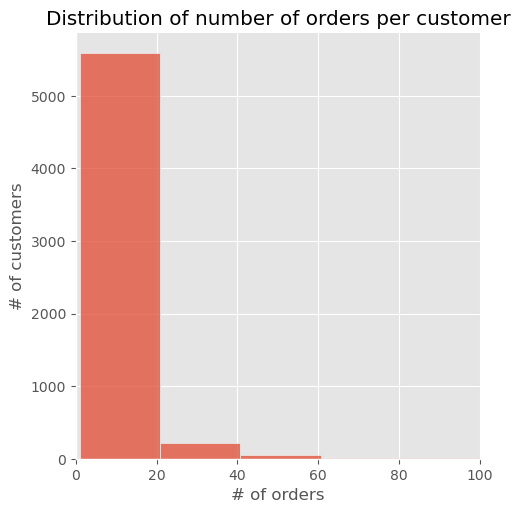

In [25]:
ax = sns.displot(n_orders, kde=False, bins=20)
ax.set(xlim=(0, 100),
       title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

In [21]:
# create two variables: month of order and cohort (first purchase assumption)
data['order_month'] = data['OrderDate'].dt.to_period('M')
data['cohort'] = data.groupby('CustomerID')['OrderDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [23]:
# calculate unique monthly customer count at the cohort level 
df_cohort = data.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
  

In [24]:
df_cohort.head(10)

,cohort,order_month,n_customers,period_number
0,2009-12,2009-12,955,0
1,2009-12,2010-01,337,1
2,2009-12,2010-02,319,2
3,2009-12,2010-03,406,3
4,2009-12,2010-04,363,4
5,2009-12,2010-05,343,5
6,2009-12,2010-06,360,6
7,2009-12,2010-07,327,7
8,2009-12,2010-08,321,8
9,2009-12,2010-09,346,9


In [25]:
# pivot the data into a form of the matrix
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [26]:
cohort_pivot.head(26)

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
cohort,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,359.0,270.0,233.0,289.0,251.0,289.0,270.0,248.0,244.0,301.0,291.0,389.0,188.0
2010-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,66.0,85.0,68.0,72.0,58.0,90.0,76.0,71.0,75.0,93.0,74.0,94.0,22.0,NaN
2010-02,376.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,43.0,47.0,57.0,65.0,46.0,75.0,60.0,61.0,54.0,86.0,86.0,61.0,22.0,NaN,NaN
2010-03,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,48.0,51.0,63.0,89.0,72.0,89.0,75.0,77.0,69.0,78.0,89.0,94.0,35.0,NaN,NaN,NaN
2010-04,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,31.0,32.0,22.0,41.0,41.0,46.0,46.0,46.0,41.0,44.0,53.0,66.0,17.0,NaN,NaN,NaN,NaN
2010-05,254.0,40.0,43.0,44.0,45.0,65.0,54.0,32.0,15.0,21.0,29.0,34.0,39.0,39.0,25.0,32.0,35.0,42.0,39.0,12.0,NaN,NaN,NaN,NaN,NaN
2010-06,270.0,47.0,51.0,55.0,62.0,77.0,34.0,24.0,22.0,32.0,29.0,37.0,40.0,33.0,30.0,33.0,36.0,55.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,186.0,29.0,34.0,55.0,54.0,26.0,21.0,27.0,27.0,21.0,25.0,27.0,25.0,25.0,36.0,32.0,44.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,162.0,33.0,48.0,52.0,28.0,19.0,16.0,20.0,22.0,21.0,21.0,20.0,25.0,30.0,29.0,32.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

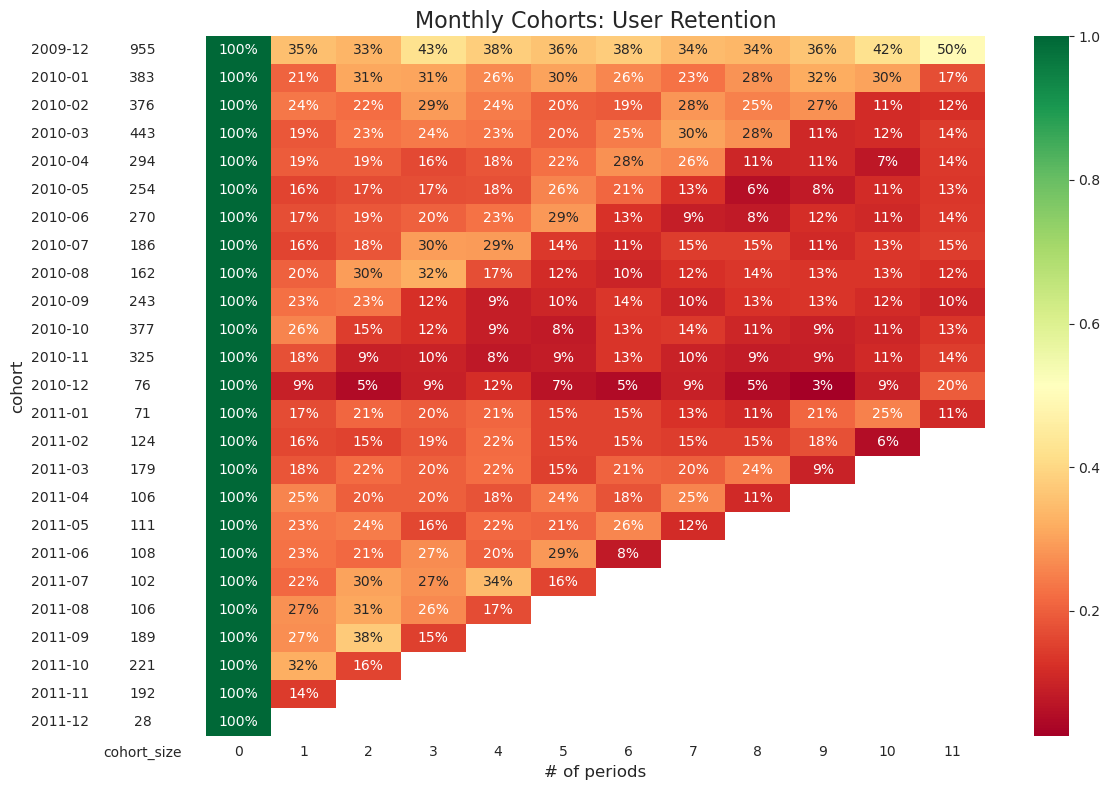

In [33]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix.iloc[:, :12],  # limit to the first 12 periods for readability
                mask=retention_matrix.iloc[:, :12].isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

plt.show()